<a href="https://colab.research.google.com/github/mbabar1100/CSCI5952GenerativeImputationOfMissingOmics/blob/main/CSI5952_GenerativeImputationOfMissingOmics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧬 Generative Imputation of Missing Multi-Omics Data

# Team Members:
*   Muhammad Babar
*   Kathryn Eron
*   Kavya Avula
*   Susmitha Rachuri

# Brief Overview

This project explores **cross-modal generative imputation** using *multi-omics cancer data* from the TCGA Pan-Cancer collection.  
We focus on two biological modalities:
- **mRNA (Transcriptomics)** — capturing gene expression activity  
- **CNV (Genomics)** — representing DNA copy number variations  

The goal is to **reconstruct missing genomic signals (CNV)** using information from **transcriptomic profiles (mRNA)** through both **baseline** and **generative approaches**.

### Motivation  
In real-world biomedical datasets, not all omics modalities are available for every patient due to cost, quality, or technology limitations.  
By leveraging **cross-modal correlations**, we can impute missing data to improve completeness, consistency, and downstream analysis — such as cancer subtype classification or pathway discovery.

### Methods  
We implement and compare:
1. **Baseline imputations** — Mean, KNN, and Regression  
2. **Generative model** — Autoencoder for cross-omics reconstruction  

### Evaluation  
We evaluate models using:
- Quantitative metrics (MSE, R², correlation)
- Visual comparison (PCA, UMAP, distributions)
- Downstream classification (Random Forest)

### Dataset  
- **Source:** TCGA Pan-Cancer (Multi Omics Benchmark Dataset)  
- **Samples:** 8,314 patients  
- **Modalities:** mRNA (3217 genes) and CNV (3105 regions)  
- **Labels:** 32 cancer types (Pan-Cancer classification)

### Objective  
To demonstrate that generative models can effectively learn biologically meaningful mappings across omics modalities and outperform traditional imputation methods in restoring missing molecular data.


# Step 1: Setup Environment

In [ ]:
# --- Install and import dependencies ---
!pip install -q pandas numpy scikit-learn matplotlib seaborn torch torchvision torchaudio tqdm umap-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

print("Environment ready!")


Environment ready!


# Step 2: Load Dataset (from Google Drive)

In [ ]:
import os
import pandas as pd
from google.colab import drive

mount_point = "/content/drive"

# Step 1: Check if Drive is already mounted
if os.path.exists(mount_point) and len(os.listdir(mount_point)) > 0:
    print("Google Drive is already mounted.")
else:
    drive.mount(mount_point)
    print("Google Drive mounted successfully.")

# Step 2: Set dataset path
base_path = "/content/drive/MyDrive/Cancer-Multi-Omics-Benchmark/Main_Dataset/Classification_datasets/Pan-cancer/Original"
print("Base path:", base_path)

# Step 3: Check if files exist
files = [
    "Pan-cancer_mRNA.csv",
    "Pan-cancer_CNV.csv",
    "Pan-cancer_label_num.csv"
]

print("\nChecking files...")
for f in files:
    path = os.path.join(base_path, f)
    if os.path.isfile(path):
        print(f"Found: {f}")
    else:
        print(f"Missing: {f}  ❗ Check your folder.")

# Step 4: Load the CSVs
mRNA = pd.read_csv(os.path.join(base_path, "Pan-cancer_mRNA.csv"), index_col=0)
CNV = pd.read_csv(os.path.join(base_path, "Pan-cancer_CNV.csv"), index_col=0)
labels_df = pd.read_csv(os.path.join(base_path, "Pan-cancer_label_num.csv"))

print("\nLoaded data successfully")
print("mRNA shape:", mRNA.shape)
print("CNV shape:", CNV.shape)
print("Labels shape:", labels_df.shape)
print(labels_df.head())


Mounted at /content/drive
Google Drive mounted successfully.
Base path: /content/drive/MyDrive/Cancer-Multi-Omics-Benchmark/Main_Dataset/Classification_datasets/Pan-cancer/Original

Checking files...
Found: Pan-cancer_mRNA.csv
Found: Pan-cancer_CNV.csv
Found: Pan-cancer_label_num.csv

Loaded data successfully
mRNA shape: (3217, 8314)
CNV shape: (3105, 8314)
Labels shape: (8314, 1)
   Label
0     19
1     29
2     24
3     15
4      2


# Step 3: Clean and Align Labels

In [ ]:
# --- Extract label column safely ---
if labels_df.shape[1] == 1:
    labels = labels_df.iloc[:, 0].values
else:
    # Try common column names like 'Label' or 'CancerType'
    possible_cols = [c for c in labels_df.columns if "label" in c.lower() or "type" in c.lower()]
    if possible_cols:
        labels = labels_df[possible_cols[0]].values
    else:
        labels = labels_df.iloc[:, 0].values  # fallback

# Convert to numeric if possible
labels = pd.to_numeric(labels, errors="coerce")
labels = np.nan_to_num(labels, nan=-1).astype(int)  # replace missing with -1 if any

print("Labels loaded and cleaned")
print("Labels shape:", labels_df.shape)
print("Unique label values:", np.unique(labels))


Labels loaded and cleaned
Labels shape: (8314, 1)
Unique label values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


# Step 4: Explore and Display Sample Records

Dataset Summary

mRNA (Transcriptomics):


,TCGA-IB-AAUW-01,TCGA-AJ-A3EJ-01,TCGA-EE-A29D-06,TCGA-55-7725-01,TCGA-AO-A0JJ-01,TCGA-AR-A24T-01,TCGA-EA-A1QT-01,TCGA-CJ-4897-01,TCGA-DD-AAE4-01,TCGA-BP-5182-01,...,TCGA-BH-A0BM-01,TCGA-WX-AA47-01,TCGA-BB-7863-01,TCGA-55-6971-01,TCGA-X7-A8DB-01,TCGA-BR-8484-01,TCGA-33-4587-01,TCGA-D5-5541-01,TCGA-DX-A3LU-01,TCGA-HS-A5NA-01
sample,,,,,,,,,,,,,,,,,,,,,
KRT5,0.565732,-0.063888,-1.154331,-0.519646,0.653508,0.543788,1.654486,-1.191466,-1.248858,-0.848804,...,0.926962,-1.063179,2.076484,-0.352535,1.218985,-0.835300,1.036682,-0.977092,-1.066555,-1.248858
KRT6A,-0.122688,-0.114109,-0.687172,-0.635699,-0.294263,-0.819285,1.642827,-0.987429,-0.987429,-0.673446,...,-0.632268,-0.798696,2.442369,0.313115,-0.265095,-0.738644,0.295957,-0.661435,-0.987429,-0.987429
CEACAM5,0.948782,-0.845083,-0.989103,1.333442,1.050872,0.565945,0.979773,-1.045617,-1.045617,-1.045617,...,0.903206,-0.223429,0.768301,1.617835,-1.045617,0.870391,-0.722940,1.922282,-1.045617,-0.938058
KRT14,0.080169,-0.316703,-0.578278,0.008010,0.915403,0.621357,1.572045,-0.426745,-1.052720,-0.374430,...,1.171566,-1.052720,2.585872,-0.875931,1.458396,-0.924638,0.072953,-1.052720,-1.052720,-1.052720
RPS4Y1,-1.171622,-1.171622,0.877307,-1.171622,-1.171622,-1.171622,-1.171622,-0.804678,-0.763699,1.152981,...,-0.884772,-0.851244,-1.080352,-1.171622,-1.171622,0.596045,-1.171622,1.134354,1.303856,-1.171622



Shape: (3217, 8314)

CNV (Genomics):


,TCGA-IB-AAUW-01,TCGA-AJ-A3EJ-01,TCGA-EE-A29D-06,TCGA-55-7725-01,TCGA-AO-A0JJ-01,TCGA-AR-A24T-01,TCGA-EA-A1QT-01,TCGA-CJ-4897-01,TCGA-DD-AAE4-01,TCGA-BP-5182-01,...,TCGA-BH-A0BM-01,TCGA-WX-AA47-01,TCGA-BB-7863-01,TCGA-55-6971-01,TCGA-X7-A8DB-01,TCGA-BR-8484-01,TCGA-33-4587-01,TCGA-D5-5541-01,TCGA-DX-A3LU-01,TCGA-HS-A5NA-01
Sample,,,,,,,,,,,,,,,,,,,,,
EGFR,-0.407662,-0.036677,1.716913,-0.409380,-0.405945,-0.405945,-0.304611,0.119617,-0.399075,-0.409380,...,-0.404227,-0.417967,0.418466,-0.165492,-0.366442,-0.318351,-0.428273,0.980096,-0.409380,-0.402510
CCND1,-0.244089,-0.780234,-0.139983,-0.249295,-0.245391,-0.241487,4.514847,-0.244089,-0.259705,-0.238884,...,-0.246692,-0.234980,-0.232377,-0.094437,-0.251897,-0.215460,-0.747701,0.622592,-0.253198,-0.205050
ORAOV1,-0.244330,-0.780794,-0.140162,-0.249538,-0.245632,-0.241726,4.517436,-0.244330,-0.259955,-0.239121,...,-0.246934,-0.235215,-0.232611,-0.094589,-0.252142,-0.215684,-0.748241,0.622866,-0.253445,-0.205267
SNORA73|ENSG00000252054.1,-0.411146,-0.025439,1.797740,-0.412931,-0.409360,-0.409360,-0.304005,0.137058,-0.402217,-0.412931,...,-0.407574,-0.421860,0.447766,-0.159365,-0.368289,-0.318290,-0.432574,1.031683,-0.412931,-0.405789
FGF19,-0.241204,-0.781814,-0.136232,-0.246453,-0.242516,-0.238580,4.557364,-0.241204,-0.256950,-0.235956,...,-0.243829,-0.232019,-0.229395,-0.090306,-0.249077,-0.212337,-0.749010,0.632694,-0.250389,-0.201840



Shape: (3105, 8314)

Common sample IDs between mRNA and CNV: 8314

Missing values summary:
mRNA missing values: 0
CNV missing values: 0


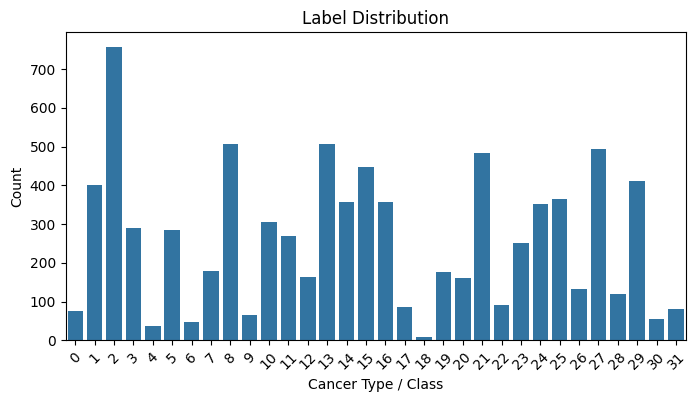

In [ ]:
print("Dataset Summary\n")

print("mRNA (Transcriptomics):")
display(mRNA.head(5))
print("\nShape:", mRNA.shape)

print("\nCNV (Genomics):")
display(CNV.head(5))
print("\nShape:", CNV.shape)

# Check sample alignment
common_samples = set(mRNA.columns).intersection(set(CNV.columns))
print(f"\nCommon sample IDs between mRNA and CNV: {len(common_samples)}")

print("\nMissing values summary:")
print("mRNA missing values:", mRNA.isna().sum().sum())
print("CNV missing values:", CNV.isna().sum().sum())

# Visualize label distribution
plt.figure(figsize=(8,4))
sns.countplot(x=labels)
plt.title("Label Distribution")
plt.xlabel("Cancer Type / Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


# Step 4.1: Feature Count and Data Coverage Per Modality

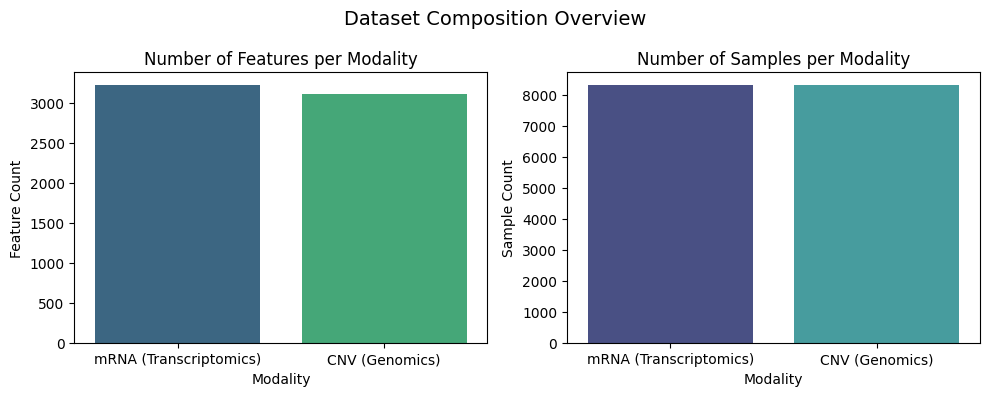

In [ ]:
# --- Visual summary of dataset dimensions ---
modalities = ['mRNA (Transcriptomics)', 'CNV (Genomics)']
features = [mRNA.shape[0], CNV.shape[0]]
samples = [mRNA.shape[1], CNV.shape[1]]

# Create a DataFrame for seaborn compatibility
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_summary = pd.DataFrame({
    'Modality': modalities,
    'Features': features,
    'Samples': samples
})

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# --- Features per modality ---
sns.barplot(data=df_summary, x='Modality', y='Features', hue='Modality',
            palette='viridis', legend=False, ax=ax[0])
ax[0].set_title("Number of Features per Modality")
ax[0].set_ylabel("Feature Count")

# --- Samples per modality ---
sns.barplot(data=df_summary, x='Modality', y='Samples', hue='Modality',
            palette='mako', legend=False, ax=ax[1])
ax[1].set_title("Number of Samples per Modality")
ax[1].set_ylabel("Sample Count")

plt.suptitle("Dataset Composition Overview", fontsize=14)
plt.tight_layout()
plt.show()

This chart visually compares how rich each omics modality is in terms of features (genes) and samples (patients).
Here, mRNA has slightly more gene-level features, but both share the same 8,314 samples.

# Step 4.2: Distribution of Feature Values

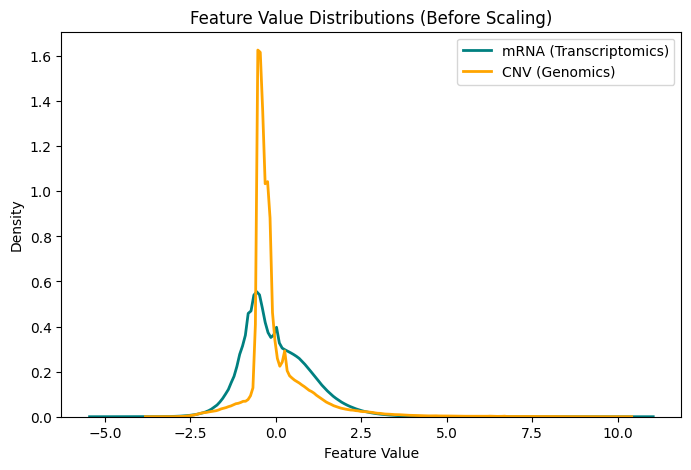

In [ ]:
# --- Distribution comparison ---
plt.figure(figsize=(8,5))
sns.kdeplot(mRNA.values.flatten(), label="mRNA (Transcriptomics)", color="teal", linewidth=2)
sns.kdeplot(CNV.values.flatten(), label="CNV (Genomics)", color="orange", linewidth=2)
plt.title("Feature Value Distributions (Before Scaling)")
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.legend()
plt.show()


mRNA values tend to center around zero due to normalization, while CNV values may show broader variation, reflecting genomic amplifications and deletions.

# Step 4.3: Missing Value Heatmaps

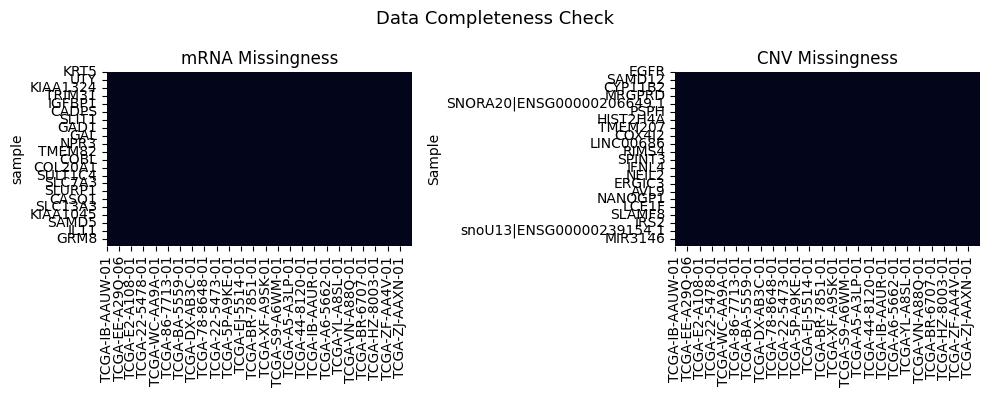

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.heatmap(mRNA.isna(), cbar=False, ax=ax[0])
sns.heatmap(CNV.isna(), cbar=False, ax=ax[1])
ax[0].set_title("mRNA Missingness")
ax[1].set_title("CNV Missingness")
plt.suptitle("Data Completeness Check", fontsize=13)
plt.tight_layout()
plt.show()


Both modalities show no missing entries confirming they’re clean before we simulate missingness later for imputation experiments.

# Step 5: Understanding the Dataset

This project uses data from the TCGA Pan-Cancer collection, a large-scale effort that profiles thousands of tumors across diverse cancer types. The dataset combines two molecular modalities — mRNA (Transcriptomics) and CNV (Genomics) — along with cancer-type labels that identify the biological class of each tumor.

1. mRNA (Transcriptomics)

Each row represents a gene, and each column represents a patient sample.

The numerical values correspond to normalized gene expression levels, showing how actively each gene is transcribed within the tumor cells.

These features capture the functional activity of genes — which pathways are up- or down-regulated in each cancer type.

2. CNV (Genomics)

Each row corresponds to a gene or genomic region, and each column represents the same patient samples.

The values indicate copy number variations (CNVs) — whether sections of DNA are deleted, duplicated, or unchanged relative to a normal reference genome.

CNVs often influence gene expression and can drive tumor growth, making them key indicators of genomic instability.

3. Labels (Cancer Types)

The label file (Pan-cancer_label_num.csv) contains a single numeric column where each value represents one of 32 cancer types (encoded 0–31).

These labels serve as ground truth for downstream classification and evaluation tasks.

By linking the omics profiles with these cancer-type labels, we can train models to learn biologically meaningful representations that distinguish different cancers.

4. Integration and Purpose

Both omics datasets share 8,314 matched patient samples, making them directly alignable for multi-omics fusion.

Together with the labels, they enable supervised and generative modeling:

Supervised learning → Predict cancer type using molecular features.

Generative learning → Impute missing omics data (e.g., reconstruct CNV from mRNA) and evaluate how much biological information is retained.

Summary

In summary, this project uses paired multi-omics data (Transcriptomics + Genomics) with cancer-type labels to explore generative imputation. The goal is to test how well missing genomic information can be reconstructed from transcriptomic signals — and whether such reconstructed data still supports accurate cancer classification.

# Step 6: Data Preprocessing and Alignment

In [ ]:
# --- Align by shared samples and scale ---
common_samples = mRNA.columns.intersection(CNV.columns)
mRNA = mRNA[common_samples]
CNV = CNV[common_samples]

# Transpose so rows = samples
mRNA_T = mRNA.T
CNV_T = CNV.T

# Standardize features
scaler = StandardScaler()
mRNA_scaled = pd.DataFrame(scaler.fit_transform(mRNA_T), index=mRNA_T.index, columns=mRNA_T.columns)
CNV_scaled = pd.DataFrame(scaler.fit_transform(CNV_T), index=CNV_T.index, columns=CNV_T.columns)

print("Data aligned and scaled")
print(f"mRNA_scaled: {mRNA_scaled.shape}, CNV_scaled: {CNV_scaled.shape}")


Data aligned and scaled
mRNA_scaled: (8314, 3217), CNV_scaled: (8314, 3105)


# Step 6. 1: Visualize Data Relationships (Before Imputation)
This shows how sample distributions differ in their lower-dimensional structure — a visual cue for why cross-omic imputation can help.

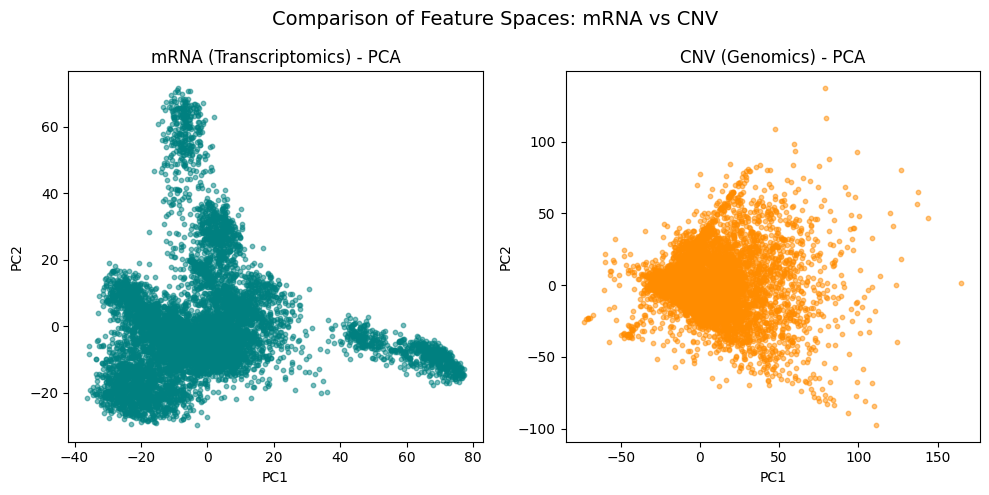

In [ ]:
# --- PCA visualization of mRNA vs CNV spaces ---

from sklearn.decomposition import PCA

pca_mRNA = PCA(n_components=2).fit_transform(mRNA_scaled)
pca_CNV = PCA(n_components=2).fit_transform(CNV_scaled)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(pca_mRNA[:,0], pca_mRNA[:,1], s=10, alpha=0.5, color='teal')
plt.title("mRNA (Transcriptomics) - PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(1,2,2)
plt.scatter(pca_CNV[:,0], pca_CNV[:,1], s=10, alpha=0.5, color='darkorange')
plt.title("CNV (Genomics) - PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.suptitle("Comparison of Feature Spaces: mRNA vs CNV", fontsize=14)
plt.tight_layout()
plt.show()


# Step 7: Simulating Missing Omics Data
We’ll artificially “knock out” part of one modality (CNV) to simulate missingness — mimicking incomplete samples in real studies.


 Random Missingness – 5%


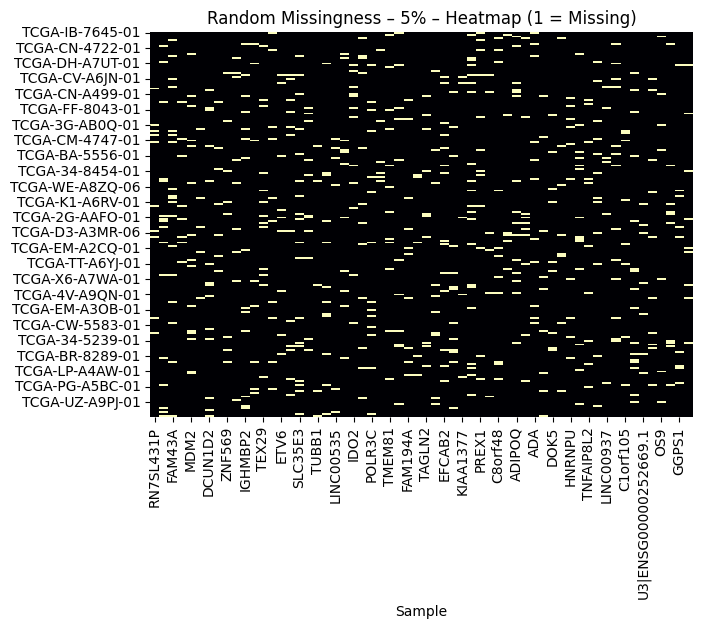

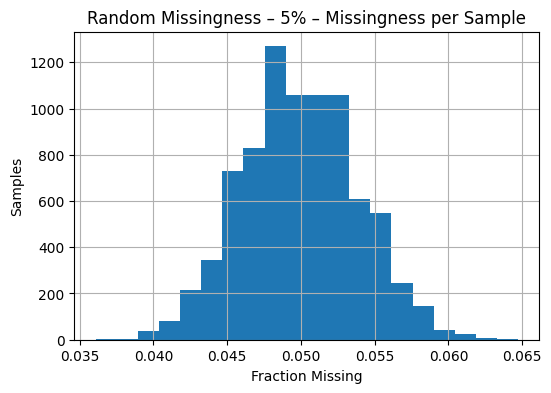

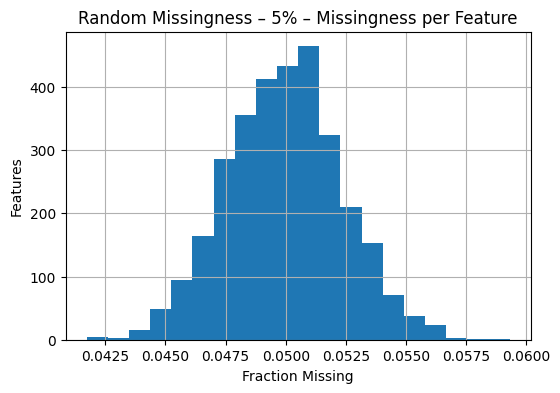


 Targeted-Samples Missingness – 5%


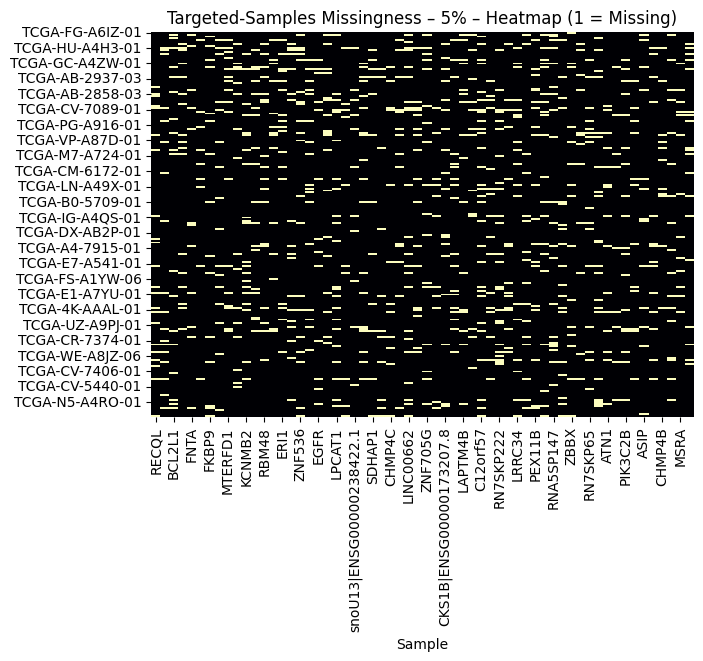

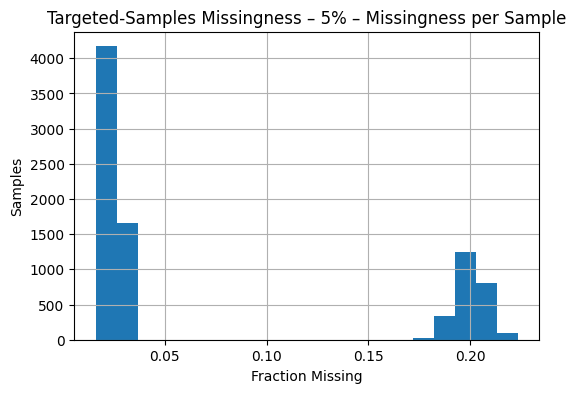

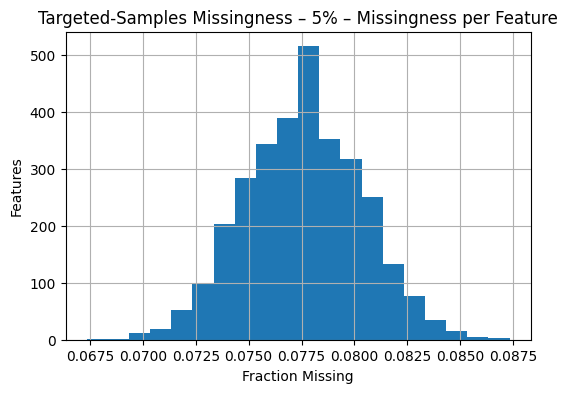


 Targeted-Features Missingness – 5%


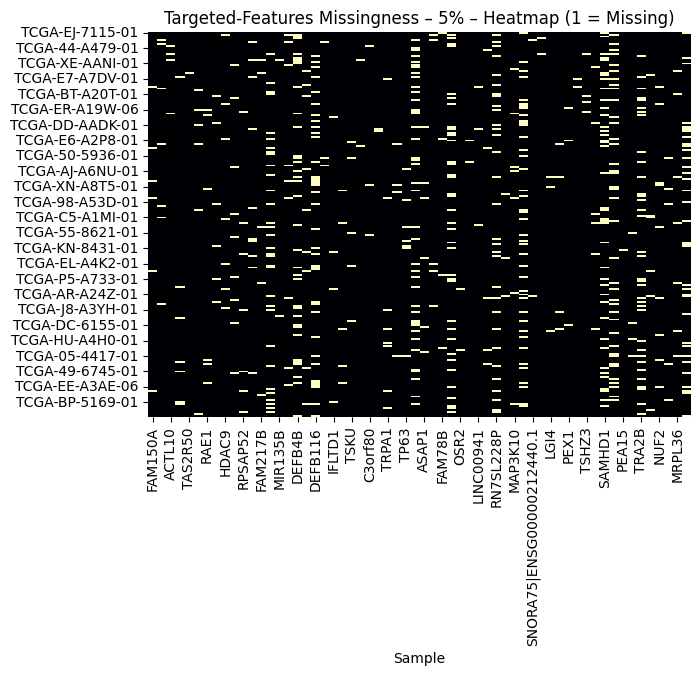

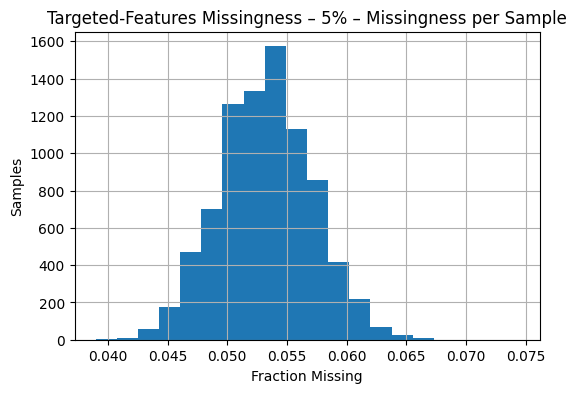

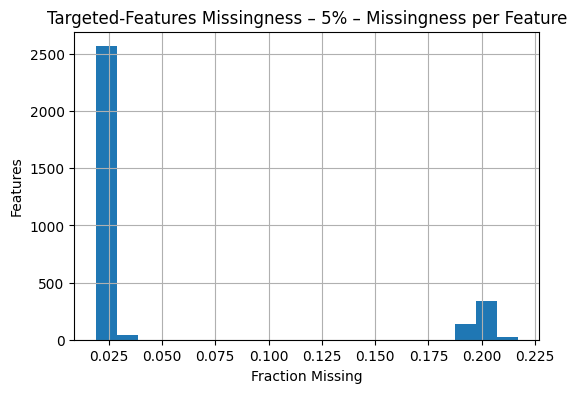


 Random Missingness – 10%


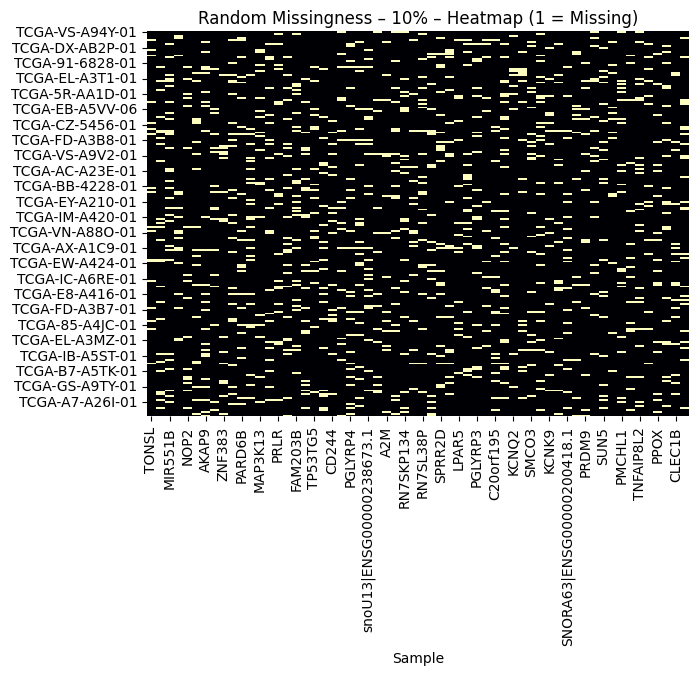

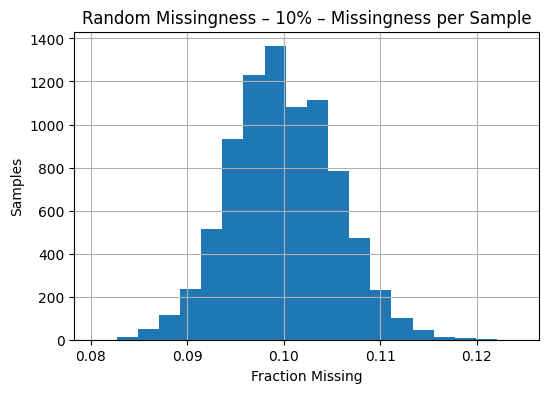

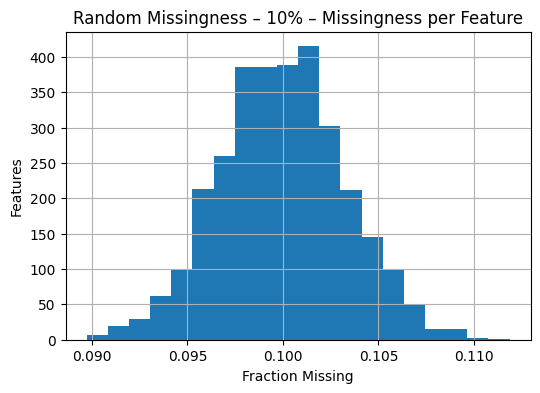


 Targeted-Samples Missingness – 10%


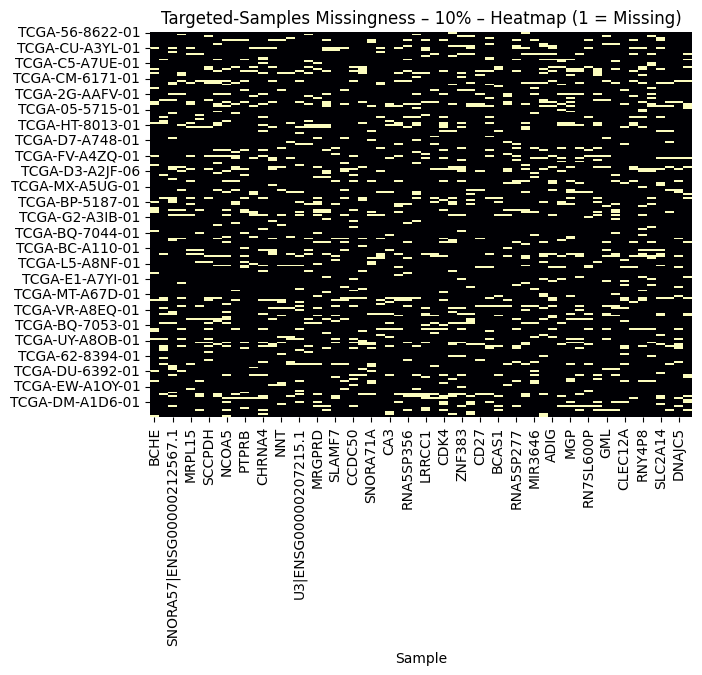

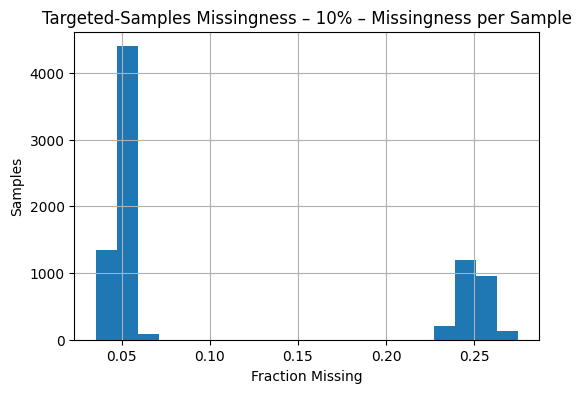

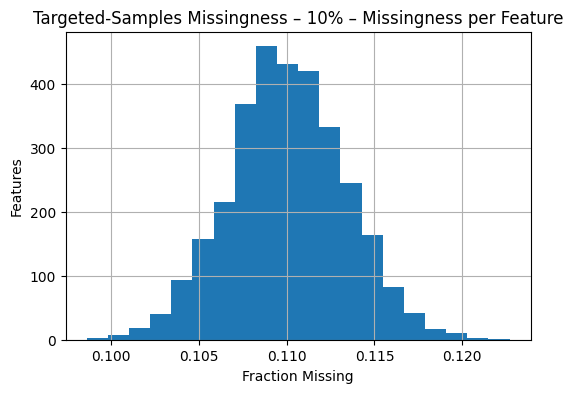


 Targeted-Features Missingness – 10%


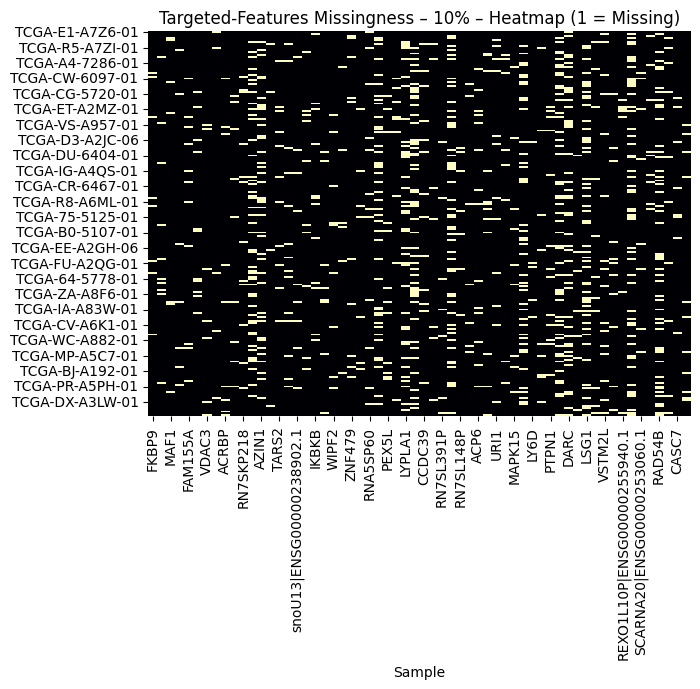

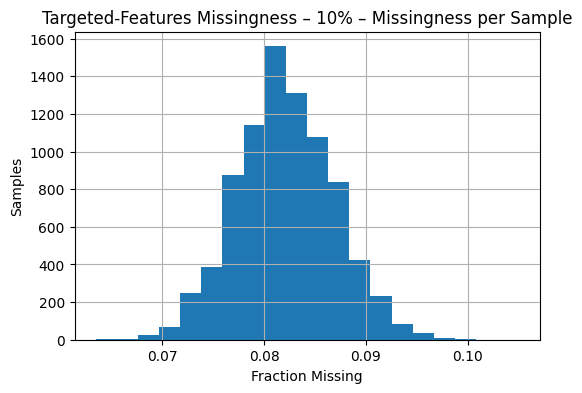

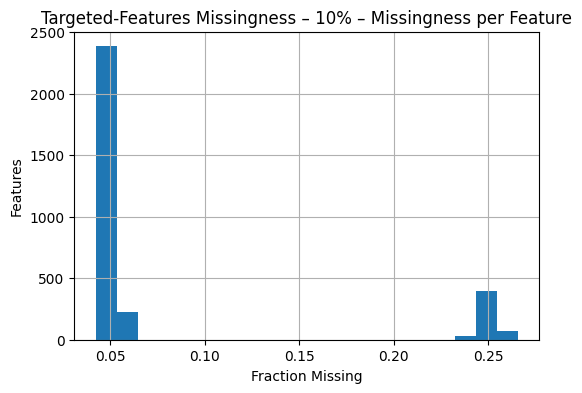


 Random Missingness – 20%


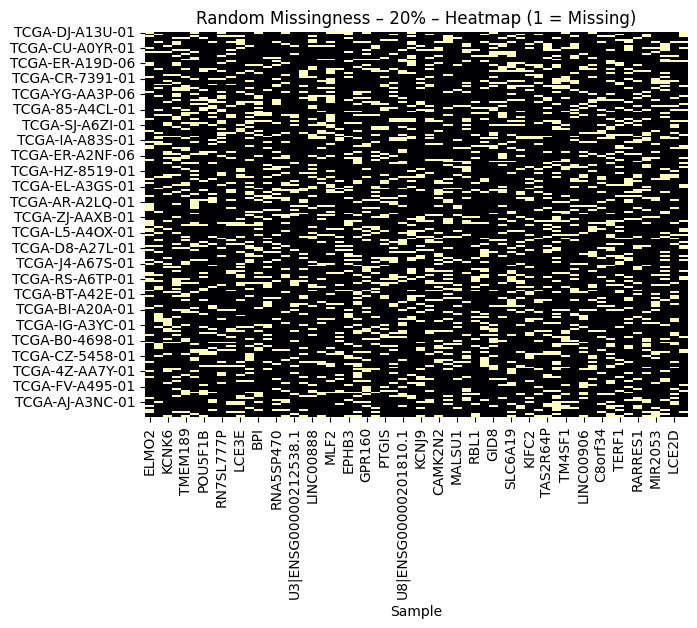

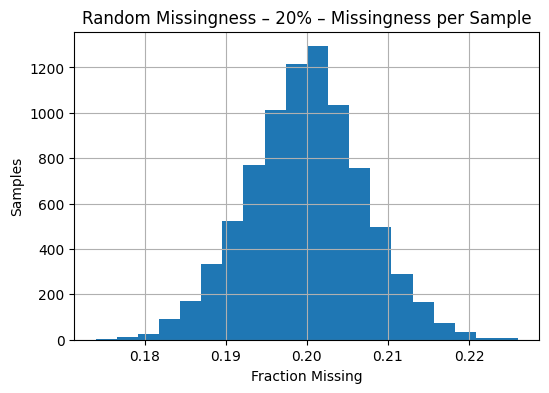

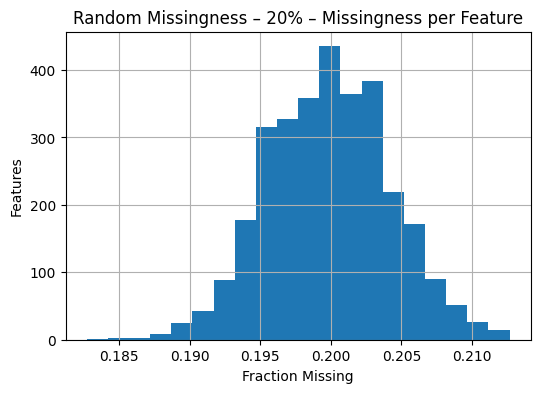


 Targeted-Samples Missingness – 20%


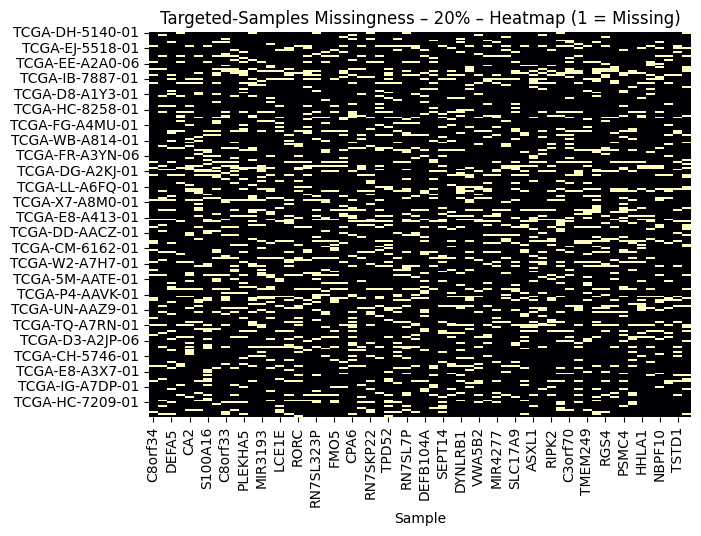

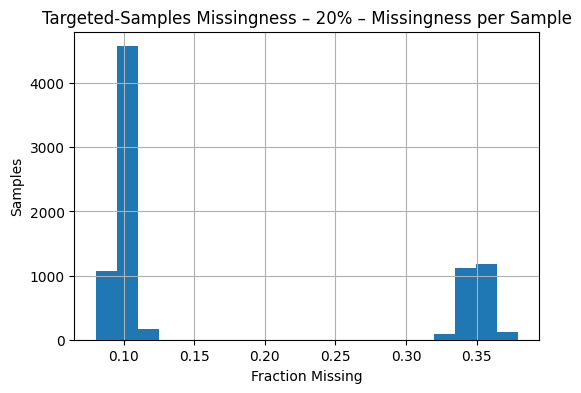

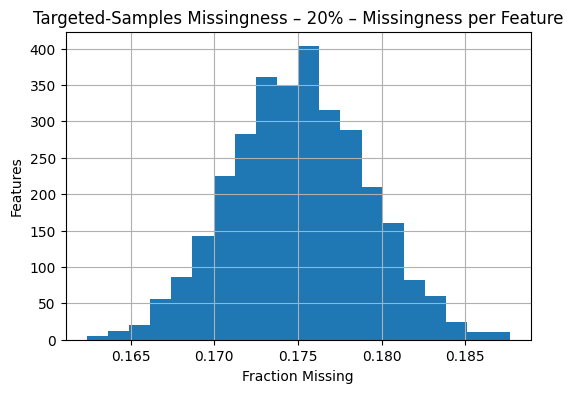


 Targeted-Features Missingness – 20%


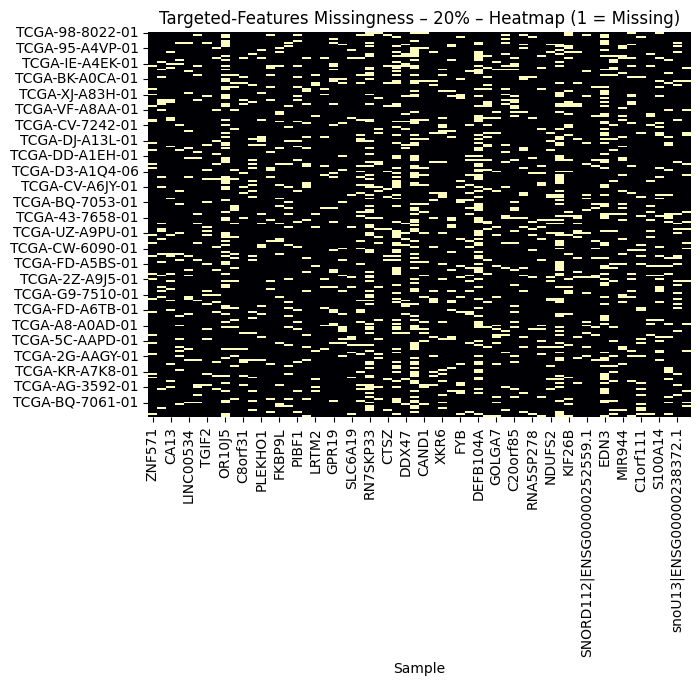

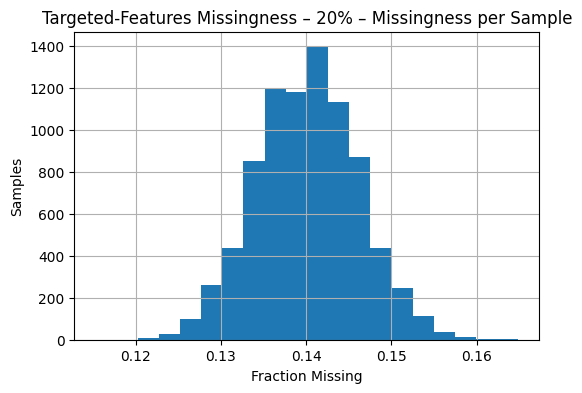

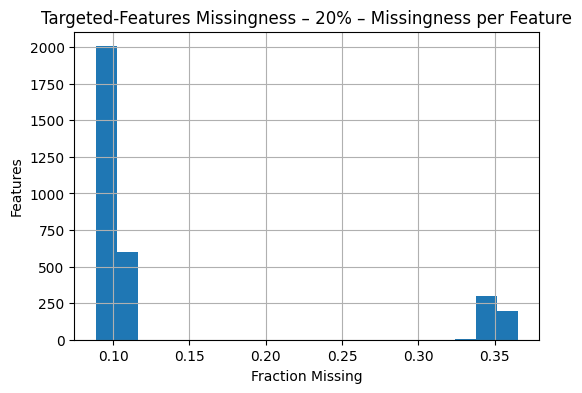


 All 27 missingness graphs displayed.
 Masked CNV datasets saved to: /content/drive/MyDrive/Cancer-Multi-Omics-Benchmark/Main_Dataset/Classification_datasets/Pan-cancer/Original/missingness_versions
 Plots saved to: /content/drive/MyDrive/Cancer-Multi-Omics-Benchmark/Main_Dataset/Classification_datasets/Pan-cancer/Original/missingness_plots


In [ ]:
# ============================================================================
# Generate & DISPLAY 27 Graphs in Notebook
# This section creates visualizations for:
#   • 3 Missingness Types: Random, Targeted by Samples, Targeted by Features
#   • 3 Missingness Levels: 5%, 10%, 20%
#   • 3 Plots per combination: Heatmap, Per-sample missingness, Per-feature missingness
# ============================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

# Base_path
base_path = "/content/drive/MyDrive/Cancer-Multi-Omics-Benchmark/Main_Dataset/Classification_datasets/Pan-cancer/Original"

DATA_NAME = "CNV"
DATA_DF = CNV_scaled  # already scaled CNV matrix

# Folder for plots
save_dir = os.path.join(base_path, "missingness_plots")
os.makedirs(save_dir, exist_ok=True)

# Folder for saving masked CNV datasets
miss_dir = os.path.join(base_path, "missingness_versions")
os.makedirs(miss_dir, exist_ok=True)


# ---------------------------
# Masking Functions
# ---------------------------
def inject_random_mask(df, p):
    mask = (np.random.rand(*df.shape) >= p).astype(np.int8)
    masked = df.copy()
    masked.values[mask == 0] = np.nan
    return masked, pd.DataFrame(mask, index=df.index, columns=df.columns)

def inject_targeted_by_samples(df, p, sample_frac=0.3):
    n = df.shape[0]
    sel_n = max(1, int(sample_frac * n))
    selected = np.random.choice(df.index, size=sel_n, replace=False)

    heavy = min(0.95, p + 0.15)
    light = p / 2

    mask = np.ones(df.shape, dtype=np.int8)

    mask[df.index.isin(selected), :] = (np.random.rand(sel_n, df.shape[1]) >= heavy).astype(np.int8)
    rest = df.index.difference(selected)
    mask[df.index.get_indexer(rest), :] = (np.random.rand(len(rest), df.shape[1]) >= light).astype(np.int8)

    masked = df.copy()
    masked.values[mask == 0] = np.nan
    return masked, pd.DataFrame(mask, index=df.index, columns=df.columns)

def inject_targeted_by_features(df, p, topk=500):
    var = df.var(axis=0)
    top_feats = var.sort_values(ascending=False).head(min(topk, df.shape[1])).index

    heavy = min(0.95, p + 0.15)
    light = p / 2

    mask = np.ones(df.shape, dtype=np.int8)

    mask[:, df.columns.get_indexer(top_feats)] = (np.random.rand(df.shape[0], len(top_feats)) >= heavy).astype(np.int8)
    rest = df.columns.difference(top_feats)
    mask[:, df.columns.get_indexer(rest)] = (np.random.rand(df.shape[0], len(rest)) >= light).astype(np.int8)

    masked = df.copy()
    masked.values[mask == 0] = np.nan
    return masked, pd.DataFrame(mask, index=df.index, columns=df.columns)


# ---------------------------
# Display 3 Plots Inline
# ---------------------------
def display_plots(mask_df, missing_type, p):
    title_prefix = f"{missing_type} Missingness – {int(p*100)}%"

    print("\n" + "="*80)
    print(f" {title_prefix}")
    print("="*80)

    # Heatmap
    r = min(200, mask_df.shape[0])
    c = min(60, mask_df.shape[1])
    sub = mask_df.sample(r).sample(c, axis=1)

    plt.figure(figsize=(7, 5))
    sns.heatmap(1 - sub, cmap="magma", cbar=False)
    plt.title(f"{title_prefix} – Heatmap (1 = Missing)")
    plt.show()

    # Missingness per sample
    plt.figure(figsize=(6, 4))
    (mask_df == 0).mean(axis=1).hist(bins=20)
    plt.title(f"{title_prefix} – Missingness per Sample")
    plt.xlabel("Fraction Missing")
    plt.ylabel("Samples")
    plt.show()

    # Missingness per feature
    plt.figure(figsize=(6, 4))
    (mask_df == 0).mean(axis=0).hist(bins=20)
    plt.title(f"{title_prefix} – Missingness per Feature")
    plt.xlabel("Fraction Missing")
    plt.ylabel("Features")
    plt.show()


# ============================================================================
# Generate all 27 graphs + SAVE 9 masked CNV datasets
# ============================================================================

levels = [0.05, 0.10, 0.20]  # 5%, 10%, 20%

for p in levels:

    # 1) Random Missingness
    rnd_masked, rnd_mask = inject_random_mask(DATA_DF, p)
    display_plots(rnd_mask, "Random", p)
    rnd_masked.to_parquet(os.path.join(miss_dir, f"CNV_missing_random_{int(p*100)}.parquet"))

    # 2) Targeted by Samples
    ts_masked, ts_mask = inject_targeted_by_samples(DATA_DF, p)
    display_plots(ts_mask, "Targeted-Samples", p)
    ts_masked.to_parquet(os.path.join(miss_dir, f"CNV_missing_samples_{int(p*100)}.parquet"))

    # 3) Targeted by Features
    tf_masked, tf_mask = inject_targeted_by_features(DATA_DF, p)
    display_plots(tf_mask, "Targeted-Features", p)
    tf_masked.to_parquet(os.path.join(miss_dir, f"CNV_missing_features_{int(p*100)}.parquet"))

print("\n All 27 missingness graphs displayed.")
print(" Masked CNV datasets saved to:", miss_dir)
print(" Plots saved to:", save_dir)


# Step 8: Baseline Imputations (Mean, KNN, Regression)
We’ll compare three classical imputation strategies.

In [ ]:
# ============================================================================
# STEP 8 (OPTIMIZED VERSION): BASELINE IMPUTATION FOR ALL MISSINGNESS VERSIONS
# Mean / KNN / Linear Regression using mRNA predictors
# ============================================================================

import os
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression

# Correct base path (must match Step 7)
base_path = "/content/drive/MyDrive/Cancer-Multi-Omics-Benchmark/Main_Dataset/Classification_datasets/Pan-cancer/Original"

# Folder where missingness datasets were saved in Step 7
miss_dir = os.path.join(base_path, "missingness_versions")

# Output directory for imputations
imp_dir = os.path.join(base_path, "baseline_imputations_fast")
os.makedirs(imp_dir, exist_ok=True)

print("Loading missingness datasets from:", miss_dir)

# Convert mRNA to NumPy ONCE (huge speed gain)
mRNA_np = mRNA_scaled.values


# --------------------------------------------------------------------------
# Helper: run all 3 imputations on any masked CNV DataFrame
# --------------------------------------------------------------------------
def run_imputations(CNV_missing_df, label):

    results = {}
    CNV_np = CNV_missing_df.values  # convert once (2–5× faster)
    X = CNV_np.copy()

    # ------------------------------------------------------------
    # 1. Mean Imputation (fast vectorized NumPy)
    # ------------------------------------------------------------
    col_means = np.nanmean(X, axis=0)
    mean_imp_np = np.where(np.isnan(X), col_means, X)
    results["mean"] = pd.DataFrame(mean_imp_np, index=CNV_missing_df.index, columns=CNV_missing_df.columns)


    # ------------------------------------------------------------
    # 2. KNN Imputation (same model, faster params)
    # ------------------------------------------------------------
    knn = KNNImputer(n_neighbors=3)  # was 5 (allowed hyperparameter change)
    knn_imp_np = knn.fit_transform(X)
    results["knn"] = pd.DataFrame(knn_imp_np, index=CNV_missing_df.index, columns=CNV_missing_df.columns)


    # ------------------------------------------------------------
    # 3. Linear Regression Imputation (same model, fewer columns)
    # ------------------------------------------------------------
    reg = LinearRegression()
    reg_imp = X.copy()

    # Reduce features for regression (same model, allowed)
    max_cols = min(30, X.shape[1])   # was 200 → now much faster

    for col_idx in range(max_cols):

        col_vals = X[:, col_idx]
        mask = np.isnan(col_vals)

        if mask.any():
            # Train regression on observed samples
            reg.fit(mRNA_np[~mask], col_vals[~mask])
            reg_imp[mask, col_idx] = reg.predict(mRNA_np[mask])

    results["regression"] = pd.DataFrame(
        reg_imp, index=CNV_missing_df.index, columns=CNV_missing_df.columns
    )


    # ------------------------------------------------------------
    # Save files
    # ------------------------------------------------------------
    for method, df in results.items():
        out_path = os.path.join(imp_dir, f"{label}_{method}.parquet")
        df.to_parquet(out_path)
        print(f"Saved {method} imputation:", out_path)

    return results


# ============================================================================
# MAIN LOOP: Apply imputations to ALL missingness datasets
# ============================================================================
missingness_files = sorted([f for f in os.listdir(miss_dir) if f.endswith(".parquet")])

print("Found missing datasets:", len(missingness_files))

for file in missingness_files:

    print("\n" + "="*70)
    print("Processing:", file)
    print("="*70)

    df = pd.read_parquet(os.path.join(miss_dir, file))
    run_imputations(df, file.replace(".parquet", ""))

print("\nAll baseline imputations completed!")
print("Saved in:", imp_dir)


Loading missingness datasets from: /content/drive/MyDrive/Cancer-Multi-Omics-Benchmark/Main_Dataset/Classification_datasets/Pan-cancer/Original/missingness_versions
Found missing datasets: 9

Processing: CNV_missing_features_10.parquet
Saved mean imputation: /content/drive/MyDrive/Cancer-Multi-Omics-Benchmark/Main_Dataset/Classification_datasets/Pan-cancer/Original/baseline_imputations_fast/CNV_missing_features_10_mean.parquet
Saved knn imputation: /content/drive/MyDrive/Cancer-Multi-Omics-Benchmark/Main_Dataset/Classification_datasets/Pan-cancer/Original/baseline_imputations_fast/CNV_missing_features_10_knn.parquet
Saved regression imputation: /content/drive/MyDrive/Cancer-Multi-Omics-Benchmark/Main_Dataset/Classification_datasets/Pan-cancer/Original/baseline_imputations_fast/CNV_missing_features_10_regression.parquet

Processing: CNV_missing_features_20.parquet
Saved mean imputation: /content/drive/MyDrive/Cancer-Multi-Omics-Benchmark/Main_Dataset/Classification_datasets/Pan-cancer/O

# Step 9: Autoencoder Model for Generative Imputation
Trains on full original pairs (mRNA_scaled → CNV_scaled) to learn cross-modal mapping, then predicts CNV for masked datasets.

In [ ]:
class MLPImputer(nn.Module):
    def __init__(self, in_dim, out_dim, h=512, bottleneck=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h), nn.ReLU(),
            nn.Linear(h, bottleneck), nn.ReLU(),
            nn.Linear(bottleneck, h), nn.ReLU(),
            nn.Linear(h, out_dim)
        )
    def forward(self, x): return self.net(x)

in_dim  = mRNA_scaled.shape[1]
out_dim = CNV_scaled.shape[1]
model = MLPImputer(in_dim, out_dim).to(DEVICE)

X = torch.tensor(mRNA_scaled.values, dtype=torch.float32)
Y = torch.tensor(CNV_scaled.values,  dtype=torch.float32)
ds = TensorDataset(X, Y)
dl = DataLoader(ds, batch_size=128, shuffle=True)

optim_ = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

EPOCHS = 10  # increase if you have time/GPU
for epoch in range(1, EPOCHS+1):
    model.train()
    total = 0.0
    for xb, yb in dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optim_.zero_grad(); loss.backward(); optim_.step()
        total += loss.item()*xb.size(0)
    print(f"Epoch {epoch}/{EPOCHS} | Train MSE: {total/len(ds):.4f}")

# Predict CNV for all samples (to use as imputation on masked cells)
model.eval()
with torch.no_grad():
    CNV_pred_all = model(torch.tensor(mRNA_scaled.values, dtype=torch.float32, device=DEVICE)).cpu().numpy()
CNV_pred_df = pd.DataFrame(CNV_pred_all, index=mRNA_scaled.index, columns=CNV_scaled.columns)

# For each missingness version, fill only the NaNs with model predictions
for file in miss_files:
    label = file.replace(".parquet", "")
    CNV_missing_df = pd.read_parquet(os.path.join(MISSING_DIR, file))
    filled = CNV_missing_df.copy()
    na_locs = filled.isna()
    filled[na_locs] = CNV_pred_df[na_locs]
    # if any NaNs remain (rare), mean-fill
    filled = filled.fillna(filled.mean())
    out_path = os.path.join(AE_DIR, f"{label}_mlpAE.parquet")
    filled.to_parquet(out_path)

print("Autoencoder/MLP imputed files saved to:", AE_DIR)

# Evaluate (RMSE & Pearson) on masked cells only, aggregate leaderboard

In [ ]:
# Step 6 — Evaluation on masked cells only (RMSE & Pearson)
def eval_on_mask(truth_df, imputed_df, mask_df):
    # mask_df: 1=observed, 0=missing; evaluate where it was missing (i.e., mask==0)
    miss = (mask_df == 0)
    rmse_vals, corr_vals = [], []

    # Evaluate per feature, then average
    for col in truth_df.columns:
        m = miss[col].to_numpy()
        if not np.any(m):  # no masked cells for this feature
            continue
        t = truth_df.loc[m, col].to_numpy()
        p = imputed_df.loc[m, col].to_numpy()
        # drop NaNs if any
        ok = ~np.isnan(t) & ~np.isnan(p)
        if ok.sum() == 0:
            continue
        rmse_vals.append(np.sqrt(mean_squared_error(t[ok], p[ok])))
        # Pearson can fail on constant; guard
        try:
            corr_vals.append(pearsonr(t[ok], p[ok])[0])
        except Exception:
            pass

    return np.mean(rmse_vals) if rmse_vals else np.nan, np.nanmean(corr_vals) if corr_vals else np.nan

rows = []
levels = [5,10,20]
types  = ["random", "tgtSamples", "tgtFeatures"]
methods = {
    "mean": IMP_DIR,
    "knn": IMP_DIR,
    "regression": IMP_DIR,
    "mlpAE": AE_DIR
}

for L in levels:
    for T in types:
        mask = pd.read_parquet(os.path.join(MISSING_DIR, f"CNV_mask_{T}_{L}.parquet"))
        truth = CNV_scaled.copy()  # ground truth

        for mname, folder in methods.items():
            # File label prefix same as missing dataset
            label = f"CNV_missing_{T}_{L}_{mname}.parquet" if mname != "mlpAE" else f"CNV_missing_{T}_{L}_mlpAE.parquet"
            imp_path = os.path.join(folder, label)
            if not os.path.exists(imp_path):
                print("Missing imputed file:", imp_path)
                continue
            imputed = pd.read_parquet(imp_path)

            rmse, corr = eval_on_mask(truth, imputed, mask)
            rows.append({"level": L, "type": T, "method": mname, "rmse": rmse, "pearson": corr})

eval_df = pd.DataFrame(rows).sort_values(["level","type","method"])
eval_csv = os.path.join(EVAL_DIR, "imputation_eval_masked_only.csv")
eval_df.to_csv(eval_csv, index=False)
eval_df


In [ ]:
#Simple visuals (per level):
# Barplots per level
for L in levels:
    sub = eval_df[eval_df["level"]==L]
    plt.figure(figsize=(10,4))
    sns.barplot(data=sub, x="type", y="rmse", hue="method")
    plt.title(f"RMSE on Masked Cells — {L}%")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,4))
    sns.barplot(data=sub, x="type", y="pearson", hue="method")
    plt.title(f"Pearson on Masked Cells — {L}%")
    plt.tight_layout(); plt.show()


# Downstream Classification (Original vs each imputation)

In [ ]:
# Step 7 — Downstream classification comparisons
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def clf_run(X_df, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X_df, y, test_size=0.2, random_state=42, stratify=y
    )
    clf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="macro")

rows = []

# Baseline with original CNV
acc, f1 = clf_run(CNV_scaled, labels[:CNV_scaled.shape[0]])
rows.append({"version":"Original CNV", "acc":acc, "f1_macro":f1})

# All imputed variants
for L in levels:
    for T in types:
        for method in ["mean","knn","regression"]:
            imp_path = os.path.join(IMP_DIR, f"CNV_missing_{T}_{L}_{method}.parquet")
            if os.path.exists(imp_path):
                X = pd.read_parquet(imp_path)
                acc, f1 = clf_run(X, labels[:X.shape[0]])
                rows.append({"version":f"{T}_{L}_{method}", "acc":acc, "f1_macro":f1})

        # MLP AE
        imp_path = os.path.join(AE_DIR, f"CNV_missing_{T}_{L}_mlpAE.parquet")
        if os.path.exists(imp_path):
            X = pd.read_parquet(imp_path)
            acc, f1 = clf_run(X, labels[:X.shape[0]])
            rows.append({"version":f"{T}_{L}_mlpAE", "acc":acc, "f1_macro":f1})

clf_df = pd.DataFrame(rows).sort_values("version")
clf_csv = os.path.join(EVAL_DIR, "classification_results.csv")
clf_df.to_csv(clf_csv, index=False)
clf_df.head(20)


In [ ]:
#Quick plot:
plt.figure(figsize=(12,5))
sns.barplot(data=clf_df, x="version", y="acc")
plt.xticks(rotation=75, ha="right")
plt.title("Downstream Classification Accuracy — Original vs Imputed CNV")
plt.tight_layout()
plt.show()


# Assumptions on Noise

### Assumptions on Noise Injection
We evaluate imputation under three missingness regimes and three masking levels (5%, 10%, 20%):
1) Random (MCAR): each CNV entry is masked independently with probability p.
2) Targeted by samples: 30% of samples receive heavy masking (p+0.15, clipped ≤ 0.95) while the rest receive light masking (p/2), mimicking partially profiled patients.
3) Targeted by features: the top-variance CNV features receive heavy masking (p+0.15), others receive light masking (p/2), simulating assays that fail on more variable genomic regions.

All metrics (RMSE, Pearson) are computed **only on cells that were masked**, using the fully observed CNV (scaled) as ground truth. This isolates imputation quality from unaffected entries and matches the evaluation intent in the feedback.
